In [1]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read csv
df = pd.read_csv("dataset.csv", sep=";")

Put the Date in the correct format and remove all wrong date format

In [3]:
# Min and Max date possible to take a good sample
date_min = pd.Timestamp("1900-01-01")
date_max = pd.Timestamp("2025-12-31")

# Clean date column even if the date is before or after a date
def clean_date(df: pd.DataFrame, column: str) -> pd.DataFrame:
    def verif_date(date: object) -> object:
        if pd.isna(date):
            return np.nan
        if (date < date_min) or (date > date_max):
            return np.nan
        return date
    # Remove non date
    df[column] = pd.to_datetime(df[column], errors="coerce")
    df[column] = df[column].apply(verif_date)
    return df


# Change Date
df = clean_date(df, "Date")
df = df.sort_values(by="Date", ascending=False)
df = df.dropna(subset=["Date"])
df["Date"] = df["Date"].astype(str)

Correct error and typo in Service, Station column

In [4]:
# Create 2 dictionnary for service column and station name
dico_service = ["national", "international"]
dico_station = pd.read_csv("station.csv")["Station"].to_numpy()

# Check if a word is next to another one and change it if it's close enought and remove the data if's incorrect
def is_word(x: object, dico: list) -> object:
    diff = 0
    if x in dico:
        return x
    for word in dico:
        diff = sum(1 for a, b in zip(x, word) if a != b)
        if diff <= 3:
            return word
    return np.nan

# Check if the value in service column is ok and replace it
def correct_service(df: pd.DataFrame, column: str) -> pd.DataFrame:
    def verif_natio(x: object) -> object:
        if isinstance(x, str):
            return is_word(x, dico_service)
        return np.nan
    df[column] = df[column].apply(verif_natio)
    return df

# Check if the value in station name is ok and replace it
def correct_station(df: pd.DataFrame, column: str) -> pd.DataFrame:
    def verif_station(x: object) -> object:
        if isinstance(x, str):
            return is_word(x, dico_station)
        return np.nan
    df[column] = df[column].apply(verif_station)
    return df

# Put everything in lowercase for service
df["Service"] = df["Service"].str.lower()

# Correct service column
df = correct_service(df, "Service")

# Put everyting in uppercase for service
df["Service"] = df["Service"].str.capitalize()

# Put the first letter in uppercase for station columns
df["Departure station"] = df["Departure station"].str.upper()
df["Arrival station"] = df["Arrival station"].str.upper()

# Correct station columns
df = correct_station(df, "Departure station")
df = correct_station(df, "Arrival station")

df = df[df["Departure station"] != df["Arrival station"]]

Remove line if the value must be an int and it's not

In [5]:
# Remove line if it's not an int
def clean_not_int(df: pd.DataFrame, column: str) -> pd.DataFrame:
    def verif_int(x: object) -> object:
        if isinstance(x, float) and x.is_integer():
            return int(x)
        return np.nan
    df[column] = df[column].apply(verif_int)
    return df

df = clean_not_int(df, "Number of scheduled trains")
df = clean_not_int(df, "Number of cancelled trains")
df = clean_not_int(df, "Number of trains delayed at departure")
df = clean_not_int(df, "Number of trains delayed > 15min")
df = clean_not_int(df, "Number of trains delayed > 30min")
df = clean_not_int(df, "Number of trains delayed > 60min")

Clean line with wrong percentage

In [6]:
# Remove line if it's over 100%
def clean_not_percent(df: pd.DataFrame, column: str) -> pd.DataFrame:
    def verif_percent(x: object) -> object:
        if x > 100:
            return np.nan
        return x
    df[column] = df[column].apply(verif_percent)
    return df

# Pct = percentage
df = clean_not_percent(df, "Pct delay due to external causes")
df = clean_not_percent(df, "Pct delay due to infrastructure")
df = clean_not_percent(df, "Pct delay due to traffic management")
df = clean_not_percent(df, "Pct delay due to station management and equipment reuse")
df = clean_not_percent(df, "Pct delay due to rolling stock")
df = clean_not_percent(df, "Pct delay due to passenger handling (crowding, disabled persons, connections)")

# Remove line if's over 1440 minutes (1 day)
def clean_not_day(df: pd.DataFrame, column: str) -> pd.DataFrame:
    def verif_day(x: object) -> object:
        if x > 1440:
            return np.nan
        return x
    df[column] = df[column].apply(verif_day)
    return df

df = clean_not_day(df, "Average journey time")


New column percentage of delay train

In [7]:
df["Pct of delay train"] = (df["Number of trains delayed at departure"] / (df["Number of scheduled trains"] - df["Number of cancelled trains"])) * 100

Clean the dataset and create a new one

In [8]:
# Remove duplicate
df = df.drop_duplicates()
df = df.drop_duplicates(subset=["Date", "Departure station", "Arrival station"], keep='first', inplace=False)

# Remove useless columns
df = df.drop(columns="Cancellation comments")
df = df.drop(columns="Departure delay comments")
df = df.drop(columns="Arrival delay comments")

# Clean every NaN and NaT value
df = df.dropna()

print df_clean and write the csv in a new csv file

In [9]:
# Write in a new file
df.to_csv("cleaned_dataset.csv", index=False)
# Remove the lines index

Data visualisation

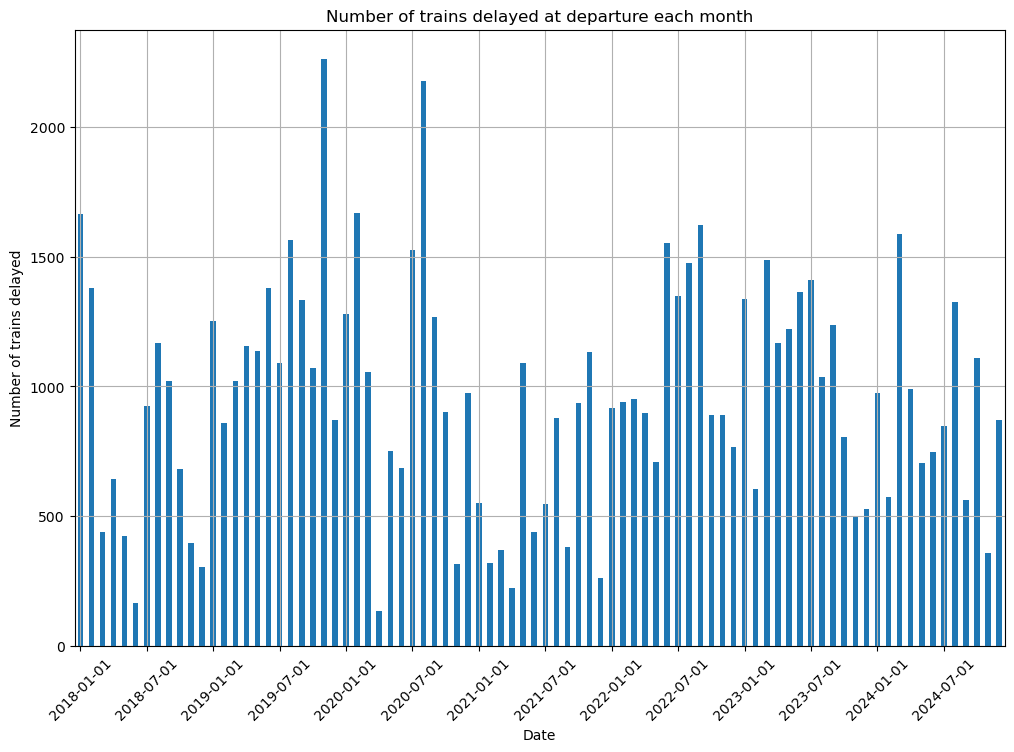

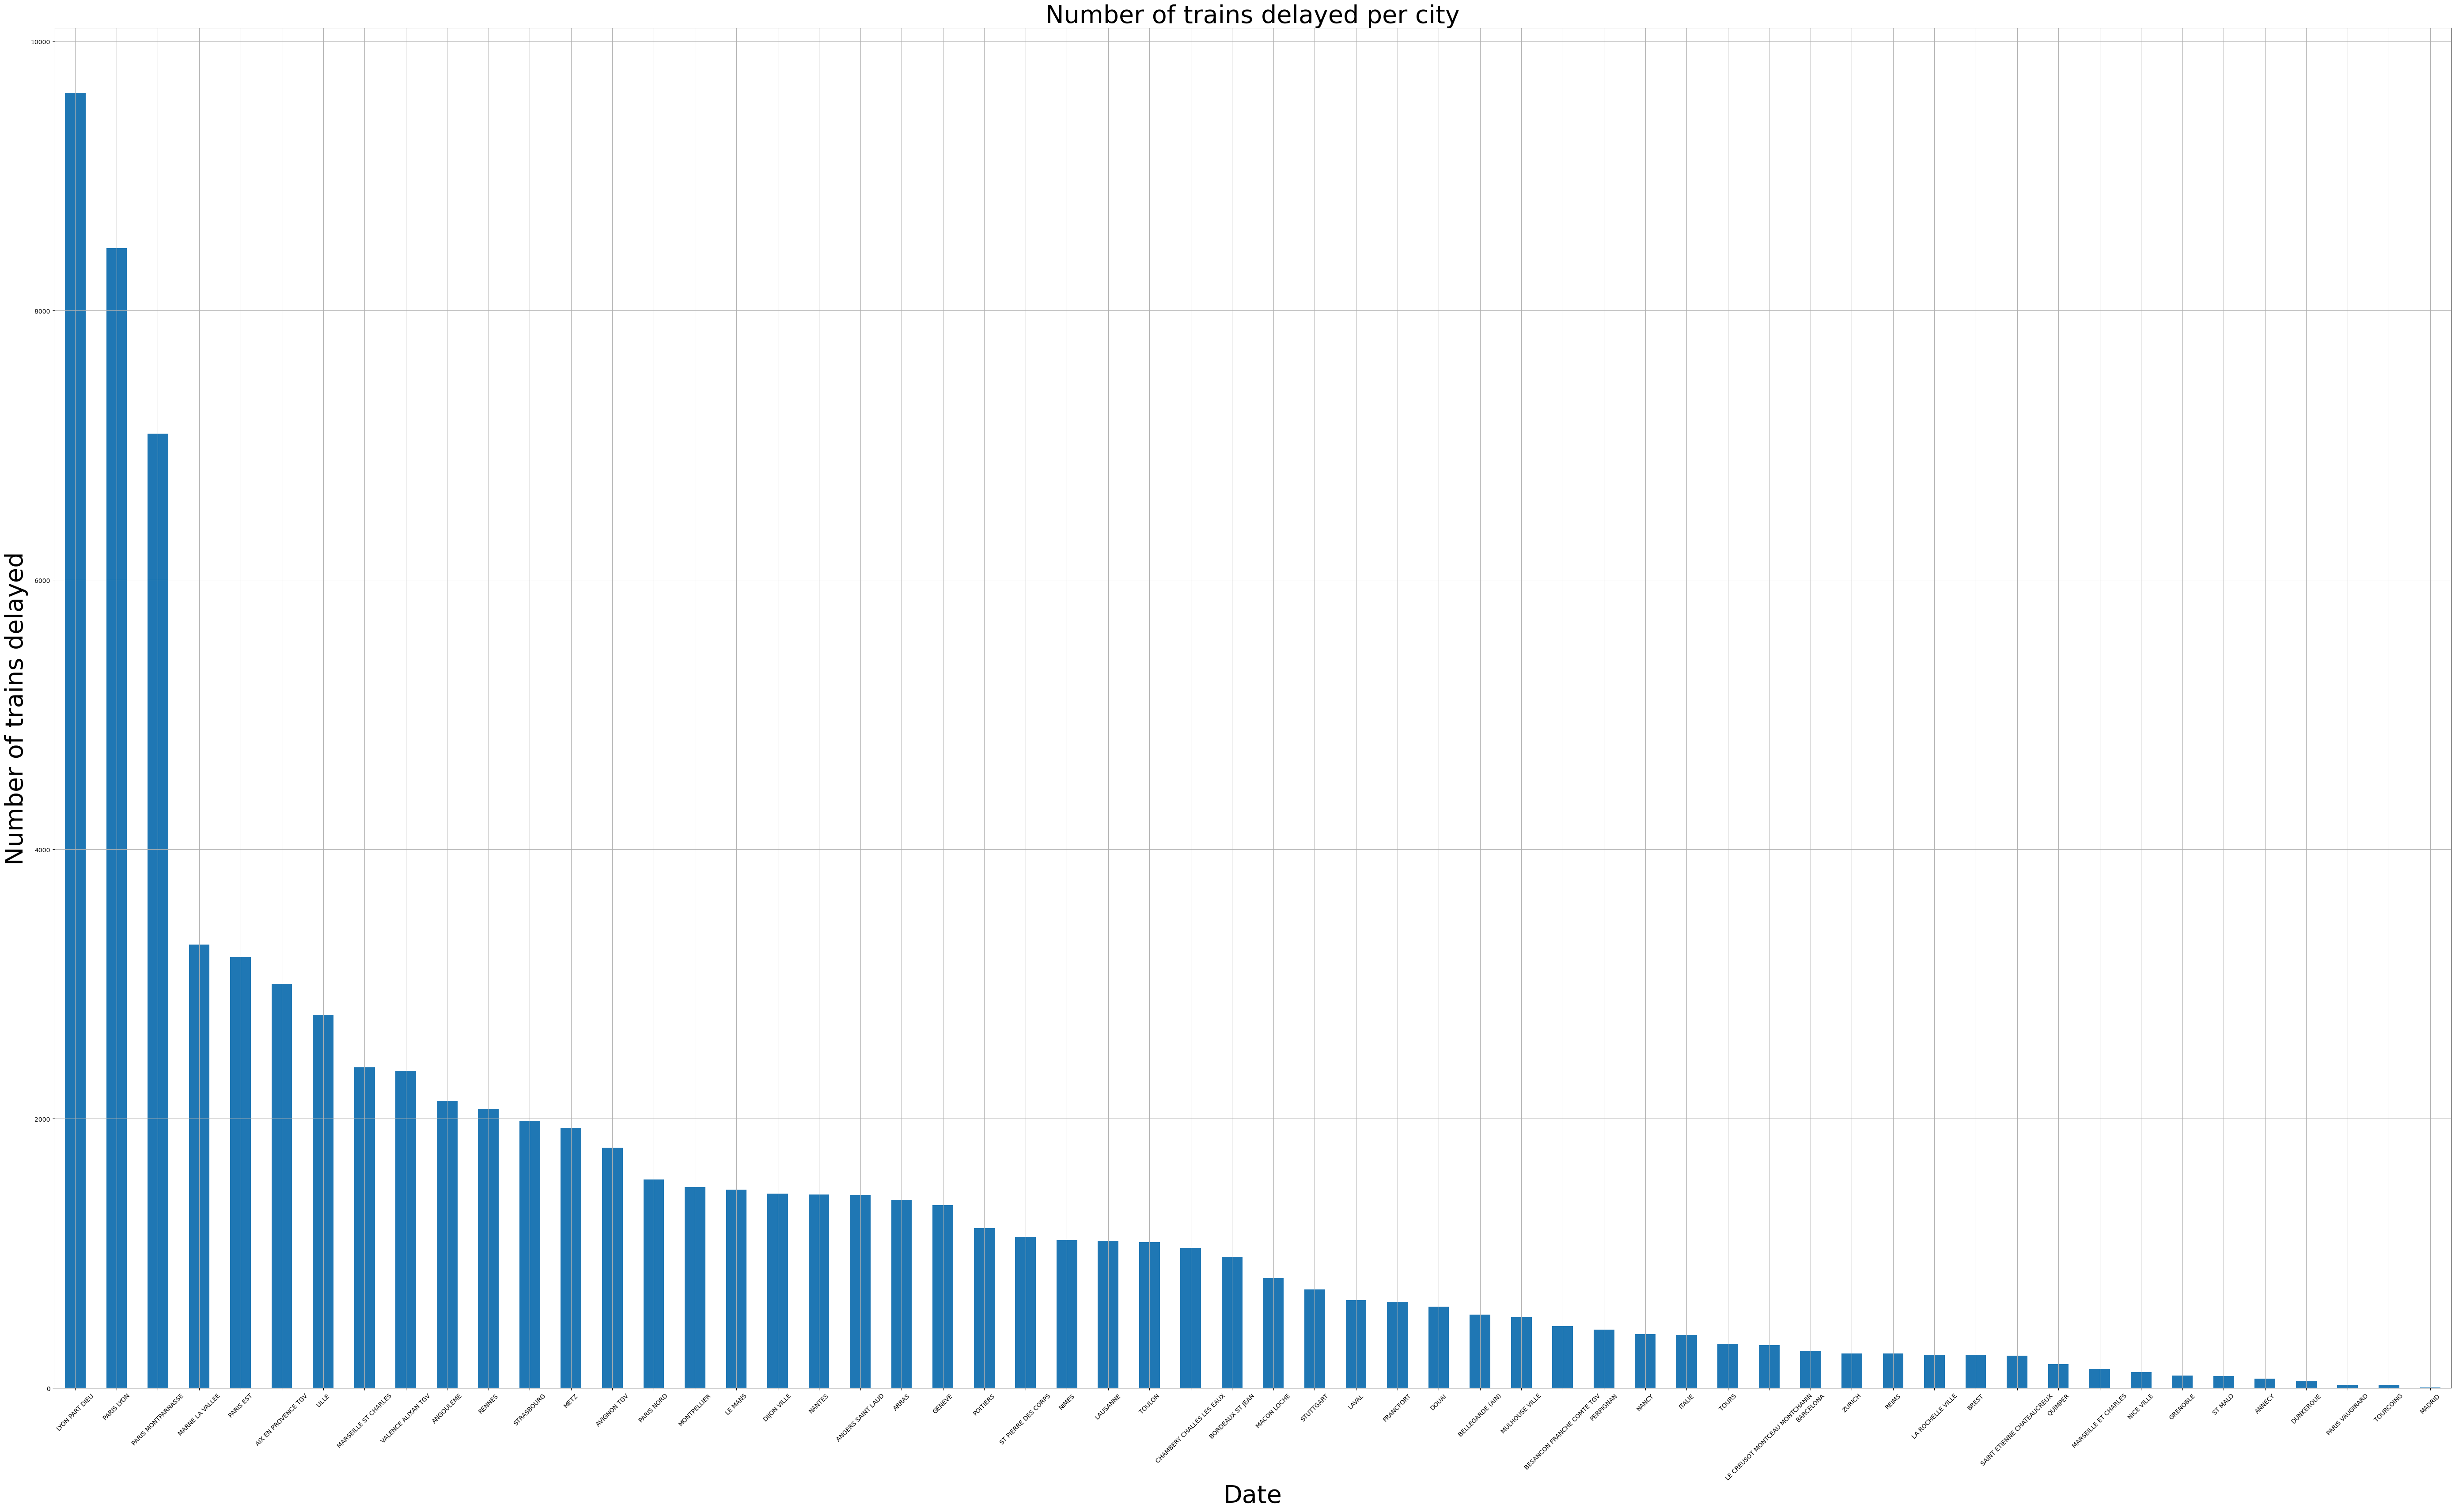

In [10]:
# First plot
plt.figure(figsize=(12, 8))

# Bar plot
delays = df.groupby("Date")["Number of trains delayed at departure"].sum()
delays.plot(kind="bar")

# Change xaxis rotation and more space in between Date for more clarity
plt.xticks(np.arange(0, df["Date"].nunique(), 6), rotation=45)

# Title
plt.title("Number of trains delayed at departure each month")

# Axis name
plt.xlabel("Date")
plt.ylabel("Number of trains delayed")

# Display
plt.grid()
plt.show()

# Second plot
plt.figure(figsize=(70, 40))

# Bar plot in descending sort
delays = df.groupby("Departure station")["Number of trains delayed at departure"].sum()
delays.sort_values(ascending=False).plot(kind="bar")

# Change xaxis rotation for more clarity
plt.xticks(rotation=45)

# Title
plt.title("Number of trains delayed per city", fontsize=40)

# Axis name
plt.xlabel("Date", fontsize=40)
plt.ylabel("Number of trains delayed", fontsize=40)

# Display
plt.grid()
plt.show()